In [1]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator
from sklearn.datasets import make_regression, make_classification

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [9]:
# Возвращает матрицу из элементов X полученных с помощью выбора с возвращением
# а также ответы y на этой выборке
# размер итоговых матрицы и столбца такой же, как и изначальных
def bootstrap(X, y):
    X = np.array(X)
    y = np.array(y)
    mask = np.random.choice(len(X), size=len(X), replace=True)  # replace = true выборка с возвращением
    #print(mask)
    X = X[mask]
    y = y[mask]
    return X, y

# Из входной матрицы свойств создаёт матрицу части свойств выбранной рандомно
# p - доля оставшихся свойств
def random_subspace_method(X, p=1.0):
    X = np.array(X)
    count_columns = X.shape[1]  # количество столбцов в матрице (количество свойств)
    # номера столцбов, которые должны быть выбраны
    mask = np.random.choice(count_columns, size=round(p * count_columns), replace=False)
    #print(mask)
    # Оставляем только выбранные столбцы из X
    X = X[:, mask]
    return X


In [3]:
# Блок тестов
X = np.array([[1, 2, 3, 4],
             [5, 6, 7, 8],
             [-1, -2, -3, -4],
             [-5, -6, -7, -8]])
y = [1, 0, 0, 1]
print(X.shape)

arr = bootstrap(X, y)
print(arr)


(4, 4)
[2 2 2 2]
(array([[-1, -2, -3, -4],
       [-1, -2, -3, -4],
       [-1, -2, -3, -4],
       [-1, -2, -3, -4]]), array([0, 0, 0, 0]))


In [4]:
# Блок тестов
random_subspace_method(X, 0.5)


[3 0]


array([[ 4,  1],
       [ 8,  5],
       [-4, -1],
       [-8, -5]])

In [5]:
X = np.arange(16).reshape(4, 4)
y = np.arange(4)

assert type(bootstrap(X, y)[0]) == np.ndarray, "wrong return type of X"
assert type(bootstrap(X, y)[1]) == np.ndarray, "wrong return type of y"
assert bootstrap(X, y)[0].shape == X.shape, "wrong shape of X"
assert bootstrap(X, y)[1].shape == y.shape, "wrong shape of y"

assert type(random_subspace_method(X)) == np.ndarray, "wrong return type"
assert random_subspace_method(X).shape == X.shape, "wrong size"
assert random_subspace_method(X, p=0.5).shape == (4, 2), "wrong size"
assert np.all(np.unique(random_subspace_method(X)) == np.unique(X)), "duplicating features (or smth even worse)"

[3 0 1 2]
[1 3 2 0]
[2 3 3 1]
[3 2 3 0]
[0 3 1 2]
[2 3 1 0]
[0 1]
[1 2 3 0]


In [53]:
class BrandNewRandomForestClassifier(BaseEstimator):
    def __init__(self, num_iterations=100, max_depth=6, p=1.0):
        self.num_iterations = num_iterations
        self.max_depth = max_depth
        self.p = p
        
    def fit(self, X, y):
        self.estimators = []
        for iter_num in range(self.num_iterations):
            
            # IT IS BEGIN OF MY CODE
            X_iter, y_iter = bootstrap(X, y)
            
            new_estimator = DecisionTreeClassifier(max_depth=self.max_depth)
            X_random = random_subspace_method(X_iter, self.p)
            new_estimator.fit(X_random, y_iter)
            
            # END OF MY CODE
            
            self.estimators.append(new_estimator)
            
    def predict_proba(self, X):
        probas = []
        
        for estimator in self.estimators:
            probas.append(estimator.predict_proba(X))
        
        return np.dstack(probas).mean(axis=2)

In [19]:
from sklearn.datasets import make_classification

X, y = make_classification()
np.mean(cross_val_score(DecisionTreeClassifier(max_depth=6), X, y, cv=3, scoring='neg_log_loss'))

-6.2079500056212025

In [54]:
np.mean(cross_val_score(BrandNewRandomForestClassifier(max_depth=6), X, y, cv=3, scoring='neg_log_loss'))

-0.74828530289311956

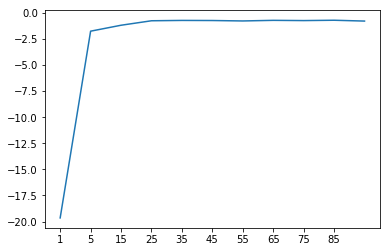

In [70]:
scores = []

all_iterations = np.array([1])
all_iterations = np.append(all_iterations, np.arange(5, 100, 10))

for iterations in all_iterations:
    algo = BrandNewRandomForestClassifier(num_iterations=iterations)
    scores.append(cross_val_score(algo, X, y, cv=3, scoring='neg_log_loss').mean())
plt.plot(scores)

_ = plt.xticks(np.arange(10), all_iterations)

In [127]:
class SimpleGBRegressor(BaseEstimator):
    def __init__(self, num_iterations=100, learning_rate=1e-1, max_depth=6):
        self.num_iterations = num_iterations
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        
    def fit(self, X, y):
        self.estimators = []
        curr_pred = np.zeros(y.shape)
        for iter_num in range(self.num_iterations):
            
            new_estimator = DecisionTreeRegressor(max_depth=self.max_depth)
            new_estimator.fit(X, y)
            self.estimators.append(new_estimator)         
            
            curr_pred = new_estimator.predict(X)
            y -= curr_pred
            
    
    def predict(self, X):
        res = np.zeros(X.shape[0])
        for estimator in self.estimators:
            res += self.learning_rate * estimator.predict(X)
        return res

In [73]:
X_data, y_data = make_regression(n_samples=1000, noise=100, n_features=10, random_state=42)
np.mean(cross_val_score(DecisionTreeRegressor(max_depth=6), X_data, y_data, cv=3, scoring='neg_mean_squared_error'))

-19028.663783906373

In [128]:
algo = SimpleGBRegressor(num_iterations=50, learning_rate = 0.1, max_depth=6)
np.mean(cross_val_score(algo, X_data, y_data, cv=3, scoring='neg_mean_squared_error'))

-22996.092362113533

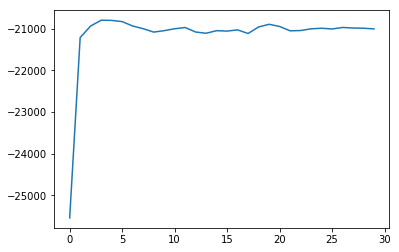

In [129]:
scores = []
for iterations in range(30):
    algo = SimpleGBRegressor(num_iterations=iterations, learning_rate=0.2)
    scores.append(cross_val_score(algo, X_data, y_data, cv=3, scoring='neg_mean_squared_error').mean())
plt.plot(scores)